In [22]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [23]:

path_to_file = 'test.csv'
source_df = pd.read_csv(path_to_file, engine='python')


In [24]:
source_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


In [25]:
# Definition of all currency codes that are present in the dataframe
all_currencies = source_df['currency'].unique()
print(f'All currency:\n{all_currencies}')

All currency:
[810 981 978 840 826 986 214 949 144 784 764 203 356 788 933 410 975 398
 376 980 578 156 985 710 704 504 756 944 498 191 348 752 800 941 977 208
  51 484 392 690 360 634 946 554 417 344 124  36 496 516 702 458 608 643
  48  32 480 446 404 524]


In [26]:
# We form 2 samples: filter the source dataframe depending on the selected code
curr_first, curr_second = 981, 826 

df_curr_first = source_df.loc[source_df['currency'] == curr_first]
df_curr_second = source_df.loc[source_df['currency'] == curr_second]

print(f'Number of transactions for currency with code {curr_first}: {len(df_curr_first)}')
print(f'Number of transactions for currency with code {curr_second}: {len(df_curr_second)}')

Number of transactions for currency with code 981: 259
Number of transactions for currency with code 826: 438


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


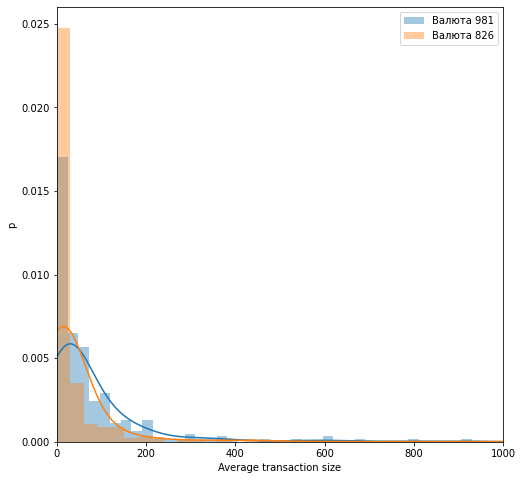

In [27]:
# Plotting a histogram and kernel density estimate
plt.figure(figsize=(8, 8))
sns.distplot(df_curr_first['amount'], kde=True, norm_hist=True, label=f'Валюта {curr_first}')
sns.distplot(df_curr_second['amount'], kde=True, norm_hist=True, label=f'Валюта {curr_second}')

plt.ylabel('p')
plt.xlabel('Average transaction size')
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [28]:
# Calculating confidence intervals for 25%, 50% and 75% quantiles
def conf_intervals(data, qn):
    # 95% quantile of Gaussian distribution
    norm_q95 = scipy.stats.norm.ppf(0.95)
    kernel = scipy.stats.gaussian_kde(data)

    p25 = len(data[data < qn[5]]) / len(data)
    sigma25 = \
        (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[5])
    p50 = len(data[data < qn[10]]) / len(data)
    sigma50 = \
        (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[10])
    p75 = len(data[data < qn[15]]) / len(data)
    sigma75 = \
        (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[15])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75

    return [conf_q25, conf_q50, conf_q75]

# Расчет квантилей
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df_curr_first['amount'], percs)
qn_second = np.percentile(df_curr_second['amount'], percs)

conf_first = conf_intervals(df_curr_first['amount'], qn_first)
conf_second = conf_intervals(df_curr_second['amount'], qn_first)

print(f'25%, 50%, 75% - confidence intervals for currency with code {curr_first}:\n {conf_first}')
print(f'25%, 50%, 75% - confidence intervals for currency with code {curr_second}:\n {conf_second}')

25%, 50%, 75% - confidence intervals for currency with code 981:
 [array([7.85585717]), array([8.73567373]), array([12.19932127])]
25%, 50%, 75% - confidence intervals for currency with code 826:
 [array([5.63450682]), array([5.16049821]), array([9.58538136])]


In [29]:
conf_first_list = []
conf_second_list = []
for element1, element2 in zip(conf_first, conf_second):
    conf_first_list.append(element1[0])
    conf_second_list.append(element2[0])

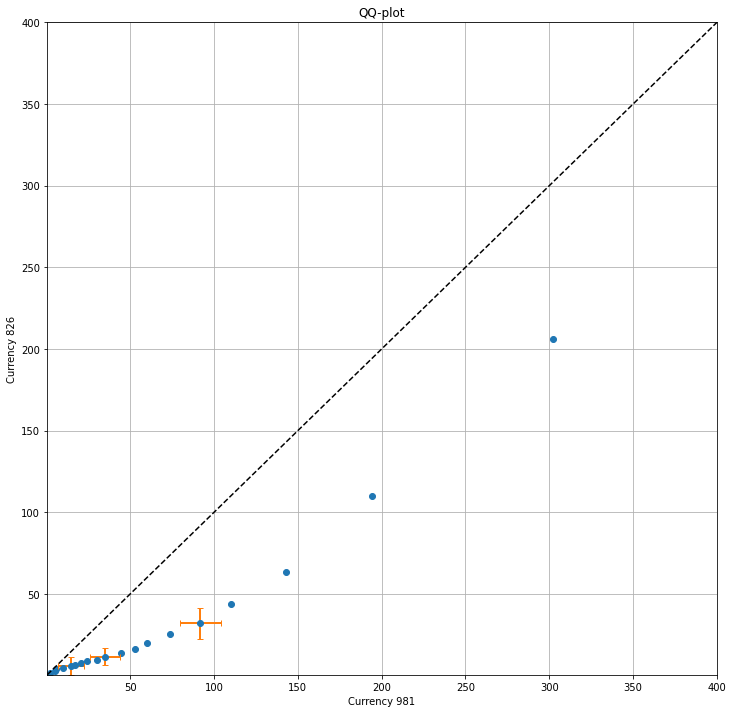

In [30]:

# Построение квантильного биплота для двух случайных величин
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel(f'Currency {curr_first}')
plt.ylabel(f'Currency {curr_second}')
plt.xlim([min_qn, 400])
plt.ylim([min_qn, 400])
plt.grid(True)

# Добавление доверительных интервалов на график
plt.errorbar(
    # [25%, 50%, 75%]
    [qn_first[5], qn_first[10], qn_first[15]],
    [qn_second[5], qn_second[10], qn_second[15]],
    xerr=conf_first_list,
    yerr=conf_second_list,
    ls='none',
    capsize=3,
    elinewidth=2
)

plt.title('QQ-plot')
plt.show()

In [31]:
# Determination of the parameters of the lognormal distribution of the average transaction value for currency 981 
x = np.linspace(np.min(df_curr_first['amount']), np.max(df_curr_first['amount']))

# The distribution parameters are determined using the fit function based on the maximum likelihood method
params = scipy.stats.lognorm.fit(df_curr_first['amount'])
pdf = scipy.stats.lognorm.pdf(x, *params)

In [32]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks = scipy.stats.kstest(df_curr_first['amount'], 'lognorm', params, N=100)
chi2 = scipy.stats.chisquare(df_curr_first['amount'])
print(ks)
print(chi2)

KstestResult(statistic=0.052088188460444385, pvalue=0.4677002347278012)
Power_divergenceResult(statistic=62723.64477399849, pvalue=0.0)


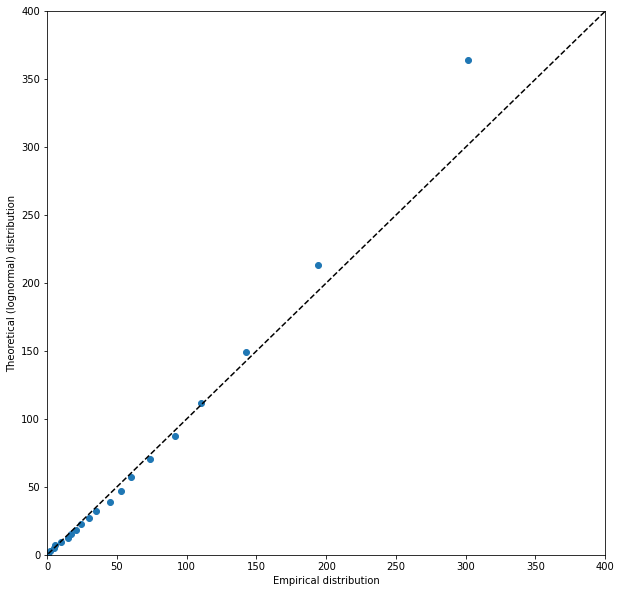

In [33]:
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(df_curr_first['amount'], percs)
qn_lognorm = scipy.stats.lognorm.ppf(percs / 100.0, *params)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_lognorm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')

plt.show()